<a href="https://colab.research.google.com/github/jiulong15/comp90051/blob/main/HF_patient(ICU%20admission%20or%20not%20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [3]:
# Import libraries
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()


project_id = 'ordinal-ember-431323-p0'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'

# Define of problem statment and patient cohort

**Problem Statment:** Build a classification model to predict whether patients diagnosed with heart failure will be admitted to the ICU or not.

**Problem Significance**:





**Patient Cohort**: Patients who have dignosis as Heart Failure during one hospitalization stay

**Define of Heart Failure Patient**: According to the paper, "Identifying Heart Failure using EMR-based algorithms", patients who have NT-proBNP test result that higher than 450 pg/ML and taking Heart Failure medications can indiciate illness of Heart Failure.(Tison,G.H et al, 2018)


## Identify patient with heart failure

### Identitify patient with abnormal NT-ProBNP

In [4]:
# Identify the item code for NT-ProBNP

query= f'''
SELECT itemid, label
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE label LIKE 'NTproBNP'

'''
itemID_HF_lab= run_query(query)
itemID_HF_lab

,itemid,label
0,50963,NTproBNP


In [20]:
# Identifdy patient who had abnormal lab result
query = f"""
SELECT subject_id,hadm_id
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50963
      AND valuenum >= 450
      and flag = 'abnormal'
      and hadm_id is not null
ORDER BY subject_id, charttime
"""
HF_lab= run_query(query)

HF_lab = HF_lab.drop_duplicates()
print(HF_lab.shape)
HF_lab.head()

(12516, 2)


,subject_id,hadm_id
0,10000935,25849114
1,10000980,20897796
2,10002430,24648311
3,10002430,26295318
4,10003400,20214994


Based on the output, 12516 unique hospitalization records have abornal NT_ProBNP that may indicate an Heart Failure Diagnose code

### Identify patients who have taken HF mediciations during one hospitaliozation stay

In [21]:
# Identify HF drug that used in hosp

query = f'''
SELECT DISTINCT gsn,drug,route, drug_type
FROM `physionet-data.mimiciv_hosp.prescriptions`
WHERE (LOWER(drug) LIKE '%eplerenone%'
   OR LOWER(drug) LIKE '%spironolactone%'
   OR LOWER(drug) LIKE '%bisoprolol%'
   OR LOWER(drug) LIKE '%carvedilol%'
   OR LOWER(drug) LIKE '%metoprolol succinate%'
   OR LOWER(drug) LIKE '%bumetanide%'
   OR LOWER(drug) LIKE '%ethacrynic acid%'
   OR LOWER(drug) LIKE '%furosemide%'
   OR LOWER(drug) LIKE '%torsemide%'
   OR LOWER(drug) LIKE '%digoxin%')
   and gsn is not null

'''
drugID_hosp= run_query(query)
drugID_hosp

,gsn,drug,route,drug_type
0,061812,carvedilol phosphate,ORAL,MAIN
1,006818,spironolactone,ORAL,MAIN
2,006816,Spironolactone,PO/NG,MAIN
3,017956,bisoprolol fumarate,ORAL,MAIN
4,017956,Bisoprolol Fumarate,ORAL,MAIN
...,...,...,...,...
135,000015,Digoxin,IJ,MAIN
136,021409,Torsemide,NG,MAIN
137,061811 061812 061813 061814,carvedilol phosphate,ORAL,MAIN
138,000019,Digoxin,J TUBE,MAIN


In [22]:
## Query prescription time for patients who have used HF mediciations where records stores in mimic_hosp
query = f"""
SELECT subject_id,hadm_id
FROM `physionet-data.mimiciv_hosp.prescriptions`
WHERE gsn IN (
    SELECT DISTINCT gsn
    FROM `physionet-data.mimiciv_hosp.prescriptions`
    WHERE (LOWER(drug) LIKE '%eplerenone%'
       OR LOWER(drug) LIKE '%spironolactone%'
       OR LOWER(drug) LIKE '%bisoprolol%'
       OR LOWER(drug) LIKE '%carvedilol%'
       OR LOWER(drug) LIKE '%metoprolol succinate%'
       OR LOWER(drug) LIKE '%bumetanide%'
       OR LOWER(drug) LIKE '%ethacrynic acid%'
       OR LOWER(drug) LIKE '%furosemide%'
       OR LOWER(drug) LIKE '%torsemide%'
       OR LOWER(drug) LIKE '%digoxin%')
      and gsn is not null
      and hadm_id is not null
      )

ORDER BY subject_id
"""
HF_drug_hosp = run_query(query)
print(HF_drug_hosp.shape)
HF_drug_hosp.head()

(533202, 2)


,subject_id,hadm_id
0,10000032,22595853
1,10000032,22841357
2,10000032,22595853
3,10000032,22841357
4,10000032,25742920


In [23]:
# Identify the HF drug ID code that used in ICU
query = f'''
SELECT DISTINCT itemid, label, category
FROM `physionet-data.mimiciv_icu.d_items`
WHERE (LOWER(label) LIKE '%eplerenone%'
   OR LOWER(label) LIKE '%spironolactone%'
   OR LOWER(label) LIKE '%bisoprolol%'
   OR LOWER(label) LIKE '%carvedilol%'
   OR LOWER(label) LIKE '%metoprolol succinate%'
   OR LOWER(label) LIKE '%bumetanide%'
   OR LOWER(label) LIKE '%ethacrynic acid%'
   OR LOWER(label) LIKE '%furosemide%'
   OR LOWER(label) LIKE '%torsemide%'
   OR LOWER(label) LIKE '%digoxin%')
   AND category = 'Medications';

'''
drugID_icu= run_query(query)
drugID_icu

,itemid,label,category
0,221794,Furosemide (Lasix),Medications
1,228340,Furosemide (Lasix) 250/50,Medications
2,229069,Digoxin (Lanoxin),Medications
3,229639,Bumetanide (Bumex),Medications


In [24]:
## Query prescription time for patients who have used HF mediciations where records stores in mimic_icu


query = f'''
SELECT  subject_id,hadm_id
FROM `physionet-data.mimiciv_icu.inputevents`
WHERE itemid IN (221794, 228340,229069, 229639)
'''
HF_drug_icu= run_query(query)
print(HF_drug_icu.shape)
HF_drug_icu.head()


(120935, 2)


,subject_id,hadm_id
0,18235859,24434690
1,10296929,22391343
2,19571384,27352581
3,13608739,25567500
4,11213546,26189768


In [25]:
# Combine to check how many patients have taken HF mediciation during the hospitalization stay


HF_drug = pd.concat([HF_drug_hosp, HF_drug_icu])
HF_drug = HF_drug.drop_duplicates()
print(HF_drug.shape)
HF_drug.head()



(131137, 2)


,subject_id,hadm_id
0,10000032,22595853
1,10000032,22841357
4,10000032,25742920
7,10000764,27897940
9,10000826,21086876


### Identify HF patients who satisify both conditions

1: patients who have NT-proBNP test result that higher than 450 pg/ML

2: patients who have taken Heart Failure medications

In [26]:
HF_patient = pd.merge(HF_lab, HF_drug, on=['subject_id','hadm_id'], how='inner')
print(HF_patient.shape)
HF_patient.head()

(11044, 2)


,subject_id,hadm_id
0,10000980,20897796
1,10002430,24648311
2,10002430,26295318
3,10003400,20214994
4,10003400,23559586


### Check ICU admission and Non-ICU admission

In [29]:
# Check hospitalization along with ICU admission records
query= f'''
SELECT subject_id,hadm_id

FROM
    `physionet-data.mimiciv_icu.icustays`
GROUP BY subject_id, hadm_id
ORDER BY
  subject_id, hadm_id

'''

icu_admission= run_query(query)
print(icu_admission.shape)
print(icu_admission.head())

(66239, 2)
   subject_id   hadm_id
0    10000032  29079034
1    10000980  26913865
2    10001217  24597018
3    10001217  27703517
4    10001725  25563031


In [33]:
icu_admission['icu_admission'] = '1'
patient_label = pd.merge(HF_patient, icu_admission, on=['subject_id','hadm_id'], how='left')
patient_label['icu_admission'] = patient_label['icu_admission'].fillna(0)
print(patient_label.shape)
patient_label

(11044, 3)


,subject_id,hadm_id,icu_admission
0,10000980,20897796,0
1,10002430,24648311,0
2,10002430,26295318,1
3,10003400,20214994,1
4,10003400,23559586,1
...,...,...,...
11039,19997367,21508795,1
11040,19997367,22967208,0
11041,19997367,22314636,0
11042,19997367,21009481,0


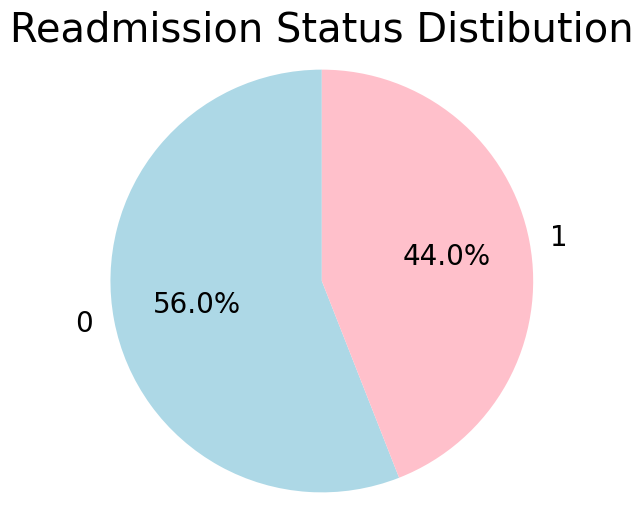

In [34]:
import matplotlib.pyplot as plt

readmission_counts = patient_label['icu_admission'].value_counts()

colors = ['lightblue', 'pink']

plt.figure(figsize=(6,6))
plt.pie(readmission_counts, labels=readmission_counts.index, autopct='%1.1f%%',
        startangle=90, colors = colors)
plt.title('Readmission Status Distibution')
plt.axis('equal')
plt.show()
